# Fit mock data to cosmology
Now that the data has been looked at a little, time to actually see how well it lines up with mock data from LIGO...

In [1]:
import h5py
import pandas as pd
import glob
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
from astropy import units as u
from astropy import constants as c
from scipy.integrate import quad

%matplotlib inline

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## First things first...
Lets just redo the final cell from `check-data.ipynb` just to keep an idea of what we're dealing with here...

dl (3643, 1000) [6.59349306 8.86409326 9.76509411 ... 6.34050207 6.05096004 7.48942135]
logwt (3643, 1000) [-2.40568924 -0.81689137 -1.84977946 ... -1.45239887 -0.10665112
 -1.24730617]
m1_detector (3643, 1000) [ 94.28824527  88.31122969 103.52489157 ...  43.06554259  78.98666661
  34.08843618]
q (3643, 1000) [0.48612534 0.67861325 0.68782264 ... 0.63571671 0.18529976 0.81651512]
eta_obs (3643,) [0.17778629 0.09639146 0.19186613 ... 0.19086518 0.1182414  0.14672015]
log_dl_obs (3643,) [2.17432848 1.35421172 2.56688951 ... 1.83623987 2.09124712 1.82413581]
log_mc_obs (3643,) [4.28150646 3.00204991 4.33963383 ... 2.81016791 3.90475574 3.30574167]
sigma_eta (3643,) [0.15271375 0.10098905 0.08593887 ... 0.06459675 0.10837015 0.19688065]
sigma_log_dl (3643,) [0.22376062 0.09773493 0.0643292  ... 0.11470738 0.15828442 0.16677532]
sigma_log_mc (3643,) [0.19221485 0.05488187 0.02299871 ... 0.07594466 0.0514777  0.10679807]
snr_obs (3643,) [10.428266   14.39574566 22.13476341 ... 16.2941247   9

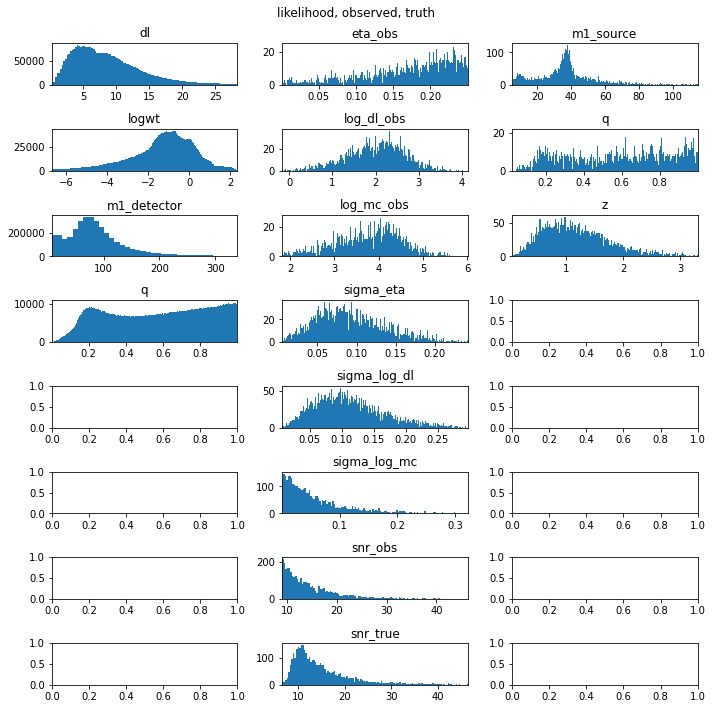

In [2]:
f = "observations.h5"
with h5py.File(f, 'r') as hf:
    keys = list(hf.keys())
    max_len = max([len(list(hf[key])) for key in keys])
    
    fig, axs = subplots(max_len, len(keys), figsize=(10, 10)) #yes I know it's only 3 keys, this keeps it general
    
    for ind_y, key in enumerate(keys):
        params = list(hf[key])
        for ind_x, param in enumerate(params):
            data = array(hf[key][param]).flatten()
#             data = array([np.random.choice(i) for i in hf[key][param]])
            print(param, hf[key][param].shape, data)
            axs[ind_x][ind_y].hist(data, bins=500)
            axs[ind_x][ind_y].set_title(param)
            
            mu = mean(data)
            sigma =std(data)
            up = min(max(data), mu+3*sigma) #upper bound of plot
            low = max(min(data), mu-3*sigma)
            
            axs[ind_x][ind_y].set_xlim(low, up)
    
#     fig.suptitle(sum([str(k) for k in keys]))
    fig.suptitle("likelihood, observed, truth") #This breaks the earlier reason, but the line above didn't work
    fig.tight_layout()

## Now lets try fitting some cosmology

A lot of this will be stuff pulled from the LIGO data fittings because there's no need to reinvent the wheel. The main difference will be that, instead of pulling one sample from each event, all events correspond to rows in this data

Now let's start with the functions for the MCMC:

In [3]:
### Functions for implementing MCMC using PyMC4

def at_interp(x, xs, ys):
    '''Custom linear interpolator'''
    x  = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    n = xs.shape[0]
    
    ind = ate.searchsorted(xs, x)
    ind = at.where(ind >= n, n-1, ind)
    ind = at.where(ind < 0, 0, ind)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1]) 
    return r*ys[ind] + (1-r)*ys[ind-1]

def Ez(z, Om, w):
    opz = 1 + z
    return at.sqrt(Om*opz*opz*opz + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w)
    I = 0.5*dz*(fz[:-1] + fz[1:]) #trapazoidally integrating
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

def make_model(ms_obs, sigma_ms_obs, dls, zmax=100):
    zinterp = expm1(linspace(log(1), log(1+zmax), 1024))

    with pm.Model() as model:
        w = pm.Normal('w', mu=-1, sigma=0.25) 

        Om = pm.Bound('Om', pm.Normal.dist(mu=0.3, sigma=0.15), lower=0, upper=1)

        h = pm.Bound('h', pm.Lognormal.dist(mu=log(0.7), sigma=0.2), lower=0.35, upper=1.4)
#         h = pm.Lognormal('h', mu=log(0.7), sigma=0.2)
        Ode = pm.Deterministic('Ode', 1-Om)
        om = pm.Deterministic('om', Om*h*h)
        ode = pm.Deterministic('ode', Ode*h*h)

        dH= pm.Deterministic('dH', 2.99792/h)
        m0 = pm.Lognormal('m0', mu=log(35), sigma=0.5)

        dCinterp = dH*dCs(zinterp, Om, w)
        dLinterp = dLs(zinterp, dCinterp)
        
        zs = pm.Deterministic('zs', at_interp(dls, dLinterp, zinterp))

        pm.Normal('m_likelihood', mu=m0*(1+zs), sigma=sigma_ms_obs, observed=ms_obs)
    return model

In [4]:
### Get m1_det and luminosity distances from data
f = "observations.h5"
n_runs = 10
m_cut = 25
n_mc = int(1e4) # number of points to find along ridge
n_m = 100
mass_array = np.zeros((n_runs, n_mc))



with h5py.File(f, 'r') as hf:
    dl_max = max(array(hf['likelihood']['dl']).flatten())
    d_ls = np.linspace(0, dl_max, n_mc)

In [5]:
x = np.random.randn(128, 12)
i = np.arange(128)
j = np.random.randint(0, 12, 128)
x[i,j]

array([ 0.72828034,  2.16427393,  0.72557404, -0.52958881, -0.21651865,
        0.22370017,  0.78068734,  0.22567655,  0.70560702,  0.13985751,
        0.38709183,  0.03943345,  1.57277708, -0.57075249,  0.57704615,
       -0.83671331,  0.45194827,  0.1611511 , -1.03007922,  1.86915336,
       -1.67579218,  0.50029241, -0.43237479, -1.0212406 ,  0.61185676,
       -1.25562223,  1.70660558, -0.27202182, -0.72862426,  1.88457466,
       -0.99160022,  0.08530047, -0.18991789, -0.42872707, -1.13348707,
       -0.51077153, -0.42905038, -0.99416488, -1.53546937,  0.11952735,
        0.22474606,  2.23946418, -0.27969408,  1.38930923,  0.32258232,
       -1.21492552, -1.87038203,  0.00868532,  0.06914562, -1.16884551,
        0.26075224, -1.7206714 ,  1.12802752, -1.07979832,  1.80230631,
        0.12068905, -2.15805244,  1.64555702, -0.74994302,  0.15359931,
        0.70829639, -0.59247934,  0.38236017, -0.62796869, -1.92364535,
        0.86447596, -0.9109306 , -1.43930055, -0.23564119, -0.36

In [6]:
with h5py.File(f, 'r') as hf:
    nevents = hf['likelihood']['dl'].shape[0]
    nsamples = hf['likelihood']['dl'].shape[1]
    print(hf['likelihood']['dl'].shape)

    event_index_arr = np.arange(nevents)
    
    for run in range(n_runs):
        print(f"Starting run {run+1} of {n_runs}")
        sample_index_arr = np.random.randint(0, nsamples,  nevents)

        m1_det = np.array(hf['likelihood']['m1_detector'])[event_index_arr, sample_index_arr]
        dl = np.array(hf['likelihood']['dl'])[event_index_arr, sample_index_arr]
        
        print(m1_det.shape, dl.shape)
    
        ### Sort out BH around 35M_sun mass bump
        mask = m1_det > m_cut

        masked_m1 = m1_det[mask]
        masked_dl = dl[mask]
    
        print(m1_det.shape, masked_m1.shape, len(masked_m1)/len(m1_det))
        print(dl.shape, masked_dl.shape) # just a sanity check that the mask works

### Set up KDE and pull out ridge

        arr = np.array([masked_dl, masked_m1])
        kde = gaussian_kde(arr)

        dlmin = 0
        dlmax=max(d_ls)
        mmin = 0
        mmax = max(masked_m1)

        DL, M = np.mgrid[dlmin:dlmax:n_mc*1j, mmin:mmax:n_m*1j]
        positions = np.vstack([DL.ravel(), M.ravel()])
        K = np.reshape(kde(positions).T, DL.shape)


        ms = np.linspace(mmin, mmax, n_m)

        for i, dl in enumerate(K):
            mass_array[run, i] = ms[np.argmax(dl)]

(3643, 1000)
Starting run 1 of 10
(3643,) (3643,)
(3643,) (3259,) 0.8945923689267088
(3643,) (3259,)
Starting run 2 of 10
(3643,) (3643,)
(3643,) (3275,) 0.8989843535547626
(3643,) (3275,)
Starting run 3 of 10
(3643,) (3643,)
(3643,) (3273,) 0.8984353554762559
(3643,) (3273,)
Starting run 4 of 10
(3643,) (3643,)
(3643,) (3270,) 0.8976118583584958
(3643,) (3270,)
Starting run 5 of 10
(3643,) (3643,)
(3643,) (3275,) 0.8989843535547626
(3643,) (3275,)
Starting run 6 of 10
(3643,) (3643,)
(3643,) (3280,) 0.9003568487510294
(3643,) (3280,)
Starting run 7 of 10
(3643,) (3643,)
(3643,) (3282,) 0.9009058468295361
(3643,) (3282,)
Starting run 8 of 10
(3643,) (3643,)
(3643,) (3278,) 0.8998078506725227
(3643,) (3278,)
Starting run 9 of 10
(3643,) (3643,)
(3643,) (3273,) 0.8984353554762559
(3643,) (3273,)
Starting run 10 of 10
(3643,) (3643,)
(3643,) (3269,) 0.8973373593192424
(3643,) (3269,)


In [7]:
print(mass_array)

[[  28.50570515   28.50570515   28.50570515 ...  840.91830188
   840.91830188  840.91830188]
 [  29.32226964   29.32226964   29.32226964 ... 1319.5021337
  1319.5021337  1319.5021337 ]
 [  34.98605423   34.98605423   34.98605423 ...  778.43970662
   778.43970662  778.43970662]
 ...
 [  27.17046707   27.17046707   27.17046707 ...  950.96634732
   950.96634732  950.96634732]
 [  36.92196301   36.92196301   36.92196301 ...  913.81858455
   913.81858455  913.81858455]
 [  28.52236142   28.52236142   28.52236142 ...  941.23792695
   941.23792695  941.23792695]]


[0.00000000e+00 1.25399585e-02 2.50799170e-02 ... 1.25361965e+02
 1.25374505e+02 1.25387045e+02]
[ 32.12425581  32.12425581  32.12425581 ... 925.95590276 925.95590276
 925.95590276]
[  3.40214478   3.40214478   3.40214478 ... 154.07519744 154.07519744
 154.07519744]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/home/tanner/.local/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
/home/tanner/.local/lib/python3.10/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 112 seconds.
The acceptance probability does not match the target. It is 0.8914, but should be close to 0.8. Try to increase the number of tuning steps.
We recommend running at least 4 chains for robust computation of convergence diagnostics


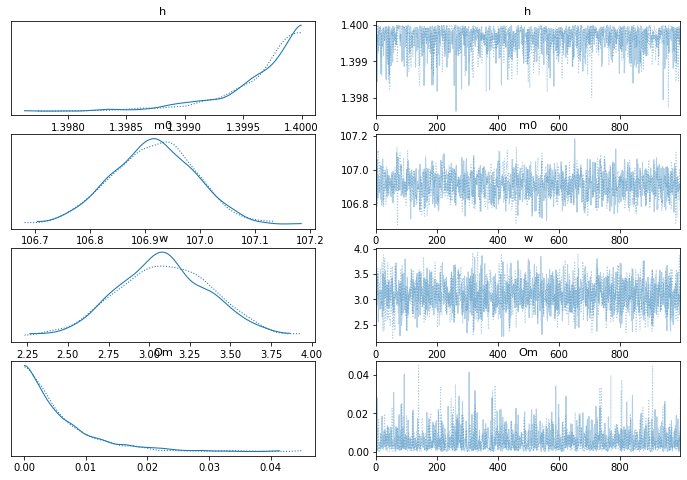

In [11]:
mu_m = np.mean(mass_array, axis=0)
sigma_m = np.std(mass_array, axis=0)
print(d_ls)
print(mu_m)
print(sigma_m)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_m, dls=d_ls/1000, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])

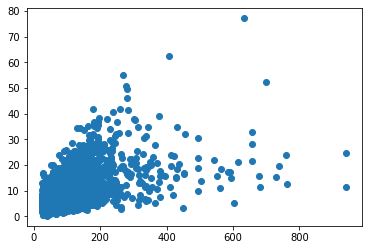

In [12]:
scatter(masked_m1, masked_dl)